In [1]:
import polars as pl

In [45]:
def data_read_pl(filename: str):
    try:
        data = pl.read_csv(filename)
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None


class FeatureEngineering:
    def __init__(self, df: pl.DataFrame, test=False):
        self.df = df
        self.test = test

    def polars_convert_str_datetime(self, field_names):
        self.df = self.df.with_columns(
            [pl.col(field).str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S").alias(field) for field in field_names]
        )
        return self

    def calculate_betting_metrics(self):
        """Calculate additional betting related metrics."""
        if self.test:
            self.df = self.df.with_columns(
                [
                    (pl.col("sum_of_real_wins") - pl.col("sum_of_real_bets")).alias("net_winnings"),
                    (
                        pl.when(pl.col("count_of_bets") == 0)
                        .then(0)
                        .otherwise(pl.col("count_of_wins") / pl.col("count_of_bets"))
                        .alias("win_rate")
                    ),
                    ((pl.col("max_window_timestamp") - pl.col("min_window_timestamp")).alias("window_duration")),
                ]
            )
        else:
            self.df = self.df.with_columns(
                [
                    (pl.col("sum_of_real_wins") - pl.col("sum_of_real_bets")).alias("net_winnings"),
                    (
                        pl.when(pl.col("next_session_delay") >= 30)
                        .then(1)
                        .otherwise(0)
                        # .cast(pl.String)
                        # .cast(pl.Categorical)
                        .alias("churn")
                    ),
                    (pl.when(pl.col("next_session_delay") >= 7).then(1).otherwise(0).alias("delay_over_7")),
                    (
                        pl.when(pl.col("count_of_bets") == 0)
                        .then(0)
                        .otherwise(pl.col("count_of_wins") / pl.col("count_of_bets"))
                        .alias("win_rate")
                    ),
                    ((pl.col("max_window_timestamp") - pl.col("min_window_timestamp")).alias("window_duration")),
                ]
            )
        self.df = self.df.with_columns((pl.col("window_duration").cast(pl.Float64) / 1_000_000 / 60).alias("window_duration_minutes"))
        return self

    @staticmethod
    def normalize_columns(data, columns):
        """Normalize specified columns using Min-Max Normalization."""
        for col in columns:
            col_min = data[col].min()
            col_max = data[col].max()
            data = data.with_columns(((pl.col(col) - col_min) / (col_max - col_min)).alias(col))
        return data

    def aggregate_by_user(self):
        """Aggregate metrics by user_id."""
        # Example aggregations
        aggregated_df = self.df.group_by("user_id").agg(
            [
                pl.sum("sum_of_real_bets").alias("total_bets"),
                pl.sum("sum_of_real_wins").alias("total_wins"),
                pl.sum("net_winnings").alias("total_net_winnings"),
                pl.mean("win_rate").alias("average_win_rate"),
                pl.max("window_duration").alias("max_session_duration"),
                pl.min("window_duration").alias("min_session_duration"),
                pl.mean("window_duration").alias("average_session_duration"),
                pl.count("session_number").alias("total_sessions"),
                pl.sum("next_session_delay").alias("total_next_session_delay"),
                pl.max("next_session_delay").alias("max_next_session_delay"),
                pl.mean("next_session_delay").alias("mean_next_session_delay"),
            ]
        )
        return aggregated_df

    def finalize(self):
        """Final method to call to get the processed DataFrame."""
        self.polars_convert_str_datetime(field_names=("min_window_timestamp", "max_window_timestamp")).calculate_betting_metrics()
        # .normalize_columns(
        #     ["sum_of_real_bets", "sum_of_real_wins", "net_winnings"]
        # )
        return self.df


def exclude_columns_pl(df_pl: pl.DataFrame, columns: list = []):
    return df_pl.drop(columns)

In [3]:
data_pl = data_read_pl("data/train.csv")  # Load your data

# Create an instance of the feature engineering class
fe = FeatureEngineering(data_pl)
processed_df = fe.finalize()
agg_data = fe.aggregate_by_user()

In [4]:
clean_train_df = processed_df.filter(pl.col("delay_over_7") == 1)
clean_train_df = exclude_columns_pl(
    clean_train_df,
    columns=[
        "user_id",
        "delay_over_7",
        "win_rate",
        "window_duration",
        "min_window_timestamp",
        "max_window_timestamp",
        "next_session_delay",
    ],
)
clean_train_df = clean_train_df.filter(pl.col("window_duration_minutes") >= 0)
print(list(clean_train_df.drop("churn").columns))
clean_train_df = fe.normalize_columns(clean_train_df, list(clean_train_df.drop("churn").columns))
clean_train_df

['session_number', 'count_of_bets', 'count_of_wins', 'sum_of_real_bets', 'sum_of_real_wins', 'highest_single_bet', 'highest_single_win', 'sum_of_deposits', 'net_winnings', 'window_duration_minutes']


session_number,count_of_bets,count_of_wins,sum_of_real_bets,sum_of_real_wins,highest_single_bet,highest_single_win,sum_of_deposits,net_winnings,churn,window_duration_minutes
f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64
0.391779,0.000417,0.00127,0.000359,0.000365,0.012122,0.012828,0.0,0.78955,1,0.013699
0.392269,0.002609,0.007622,0.002854,0.002647,0.018182,0.012828,0.0,0.785232,1,0.027397
0.392432,0.002348,0.00614,0.001335,0.001117,0.014545,0.005131,0.002128,0.786311,0,0.013699
0.392595,0.002974,0.008469,0.002169,0.002704,0.027273,0.028865,0.002128,0.793933,1,0.020548
0.392758,0.001931,0.005505,0.000893,0.001085,0.009696,0.010263,0.002128,0.791173,1,0.013699
…,…,…,…,…,…,…,…,…,…,…
0.001794,0.041273,0.033665,0.00077,0.000849,0.000758,0.004009,0.000904,0.790025,0,0.047945
0.000489,0.008766,0.021596,0.000607,0.000669,0.001249,0.001443,0.000479,0.789967,0,0.054795
0.000326,0.010279,0.007834,0.000047,0.000032,0.000038,0.000409,0.000112,0.789558,0,0.006849


# GLM model for feature selection

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import traceback

try:
    all_columns = list(clean_train_df.columns)

    # Prepare the formula for the GLM model by excluding the target variable ('Churn') from the predictors
    glm_columns = [col for col in all_columns if col != "churn"]
    print(glm_columns)
    glm_columns_formula = " + ".join(map(str, glm_columns))

    # Fit the glm with a binomial family (binary classification)
    glm_model = smf.glm(formula=f"churn ~ {glm_columns_formula}", data=clean_train_df, family=sm.families.Binomial())

    res = glm_model.fit()
    print(res.summary())
except:
    traceback.print_exc()

['session_number', 'count_of_bets', 'count_of_wins', 'sum_of_real_bets', 'sum_of_real_wins', 'highest_single_bet', 'highest_single_win', 'sum_of_deposits', 'net_winnings', 'window_duration_minutes']
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                27743
Model:                            GLM   Df Residuals:                    27733
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18485.
Date:                Sat, 11 Jan 2025   Deviance:                       36970.
Time:                        18:47:18   Pearson chi2:                 2.94e+06
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01939
Covariance Type:            nonrobust                                         
           

In [8]:
# from pandas_profiling import ProfileReport
# pd_df = clean_train_df.to_pandas()
# profile = ProfileReport(pd_df, title="Analyse train data Full v3", explorative=True)

# # Save the report as an HTML file
# profile.to_file("Analyse train data Full v3.html")

# MAIN MODELS TRAINING

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from pprint import pprint
# Assume X and y are defined
# For example:
# X, y = load_your_data_function()

# Define the preprocessor
numeric_features = list(clean_train_df.columns)  # Update with your numeric features
removed_features = ["count_of_bets", "count_of_wins", "sum_of_real_bets", "sum_of_real_wins", "highest_single_bet", "churn"]
numeric_features = [i for i in numeric_features if i not in removed_features]
categorical_features = []  # Update with your categorical features

print(numeric_features)
X = clean_train_df.drop(removed_features)
y = clean_train_df["churn"]

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# List of classifiers
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=123),
    RandomForestClassifier(random_state=123),
    AdaBoostClassifier(random_state=123),
    GradientBoostingClassifier(random_state=123),
    LogisticRegression(random_state=123),
]

# List of classifier names
classifier_names = [clf.__class__.__name__ for clf in classifiers]

scoring_metrics = {
    "roc_auc": "roc_auc_ovr",
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, average="weighted", zero_division=0),
    "recall": make_scorer(recall_score, average="weighted", zero_division=0),
    "f1_score": make_scorer(f1_score, average="weighted", zero_division=0),
}

# Collect results in a list
model_results = []
aziz = []
# Loop through the classifiers
for classifier, name in zip(classifiers, classifier_names):
    # print(name)
    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "selector",
                SelectKBest(k=len(numeric_features) + len(categorical_features)),
            ),  # Adjust based on actual number of features after encoding
            ("classifier", classifier),
        ]
    )
    results = cross_validate(pipe, X, y, cv=10, scoring=scoring_metrics, return_train_score=False, n_jobs=-1)
    payload = {
        "Classifier": name,
        "ROC AUC": results["test_roc_auc"].mean(),
        "Accuracy": results["test_accuracy"].mean(),
        "Precision": results["test_precision"].mean(),
        "Recall": results["test_recall"].mean(),
        "F1 Score": results["test_f1_score"].mean(),
        # 'Fit Time': results['fit_time'].mean(),
        # 'Score Time': results['score_time'].mean(),
    }
    model_results.append(payload)
    pprint(payload)
    aziz.append({"Classifier": name, "DATA": results})


# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(model_results)
print(results_df.to_string(index=False))


['session_number', 'highest_single_win', 'sum_of_deposits', 'net_winnings', 'window_duration_minutes']
{'Accuracy': 0.5730442006534292,
 'Classifier': 'KNeighborsClassifier',
 'F1 Score': 0.5636515011302334,
 'Precision': 0.5643689200344274,
 'ROC AUC': 0.5607077265685427,
 'Recall': 0.5730442006534292}
{'Accuracy': 0.5381527959105464,
 'Classifier': 'DecisionTreeClassifier',
 'F1 Score': 0.5376687000737569,
 'Precision': 0.5385346848222283,
 'ROC AUC': 0.5223231469110786,
 'Recall': 0.5381527959105464}
{'Accuracy': 0.5846155095253869,
 'Classifier': 'RandomForestClassifier',
 'F1 Score': 0.5686793757974931,
 'Precision': 0.572142469013879,
 'ROC AUC': 0.5758646553532207,
 'Recall': 0.5846155095253869}
{'Accuracy': 0.6179223419526231,
 'Classifier': 'AdaBoostClassifier',
 'F1 Score': 0.5597954243753184,
 'Precision': 0.6191028753326806,
 'ROC AUC': 0.6317141923991884,
 'Recall': 0.6179223419526231}
{'Accuracy': 0.6215988360386342,
 'Classifier': 'GradientBoostingClassifier',
 'F1 Score

# BEST MODEL FINE TUNING

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assume X and y are defined
# Preprocessor setup for numerical data only
numeric_features = list(X.columns)  # All features are numeric

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", numeric_transformer, numeric_features),
#     ]
# )

# Define the pipeline
pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("selector", SelectKBest()),
        ("classifier", GradientBoostingClassifier(random_state=123)),
    ]
)

# Range of features to consider in SelectKBest
# k_range = range(6, 8)  # Adjusted for numeric features only

# Parameter grid for GridSearchCV
grid = {
    "selector__k": [5],
    "classifier__max_depth": [1, 2, 3, 5],
    # "classifier__max_depth": [3, 4],
    "classifier__learning_rate": [0.03, 0.04, 0.05, 0.06],
    # "classifier__learning_rate": [0.05, 0.1],
    "classifier__n_estimators": [120, 130, 150],
    # "classifier__n_estimators": [50, 100, 150,,200,250],
    "classifier__min_samples_split": [8, 9, 10, 11],
    # "classifier__min_samples_split": [2, 5, 10,12,14],
    "classifier__min_samples_leaf": [6, 7, 8],
    # "classifier__min_samples_leaf": [1, 2, 4,5],
    "classifier__max_features": ["sqrt"],
    # "classifier__max_features": ['sqrt', 'log2']
}

# Initialize GridSearchCV
gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, cv=3, n_jobs=-1, scoring="roc_auc", verbose=1)

# Fit GridSearchCV
gridsearch.fit(X, y)

# Best parameters and score
print("Best parameters found: ", gridsearch.best_params_)
print("Best ROC AUC score: ", gridsearch.best_score_)


Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Best parameters found:  {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 130, 'selector__k': 5}
Best ROC AUC score:  0.6362982106578071


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

params = {
    "learning_rate": 0.05,
    "max_depth": 3,
    "max_features": "sqrt",
    "min_samples_leaf": 6,
    "min_samples_split": 8,
    "n_estimators": 130,
}
numeric_features = list(clean_train_df.columns)  # Update with your numeric features
removed_features = ["count_of_bets", "count_of_wins", "sum_of_real_bets", "sum_of_real_wins", "highest_single_bet", "churn"]
numeric_features = [i for i in numeric_features if i not in removed_features]
categorical_features = []  # Update with your categorical features

print(numeric_features)
X = clean_train_df.drop(removed_features)
y = clean_train_df["churn"]

# # Define feature selector with 'k' best features
# selector_k = 5
# selector = SelectKBest(score_func=f_classif, k=selector_k)

# Initialize the GradientBoostingClassifier with parameters unpacked from the dictionary
churn_classifier = GradientBoostingClassifier(
    learning_rate=params["learning_rate"],
    max_depth=params["max_depth"],
    max_features=params["max_features"],
    min_samples_leaf=params["min_samples_leaf"],
    min_samples_split=params["min_samples_split"],
    n_estimators=params["n_estimators"],
    random_state=123,
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
# Fit the model on the training data
churn_classifier.fit(X_train, y_train)

# Predict on the testing data
y_pred = churn_classifier.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC score: {roc_auc}")

['session_number', 'count_of_bets', 'count_of_wins', 'sum_of_real_bets', 'sum_of_real_wins', 'highest_single_bet', 'highest_single_win', 'sum_of_deposits', 'net_winnings', 'window_duration_minutes']
ROC AUC score: 0.5614995772508886


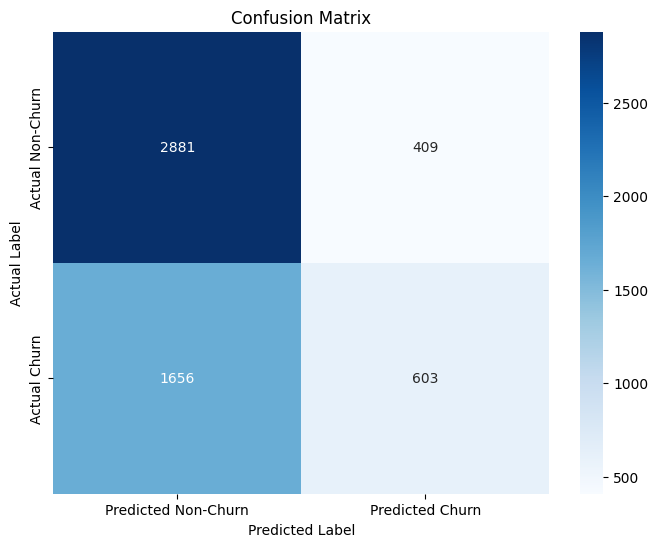

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Fit the model and make predictions as you have done previously
churn_classifier.fit(X_train, y_train)
y_pred = churn_classifier.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted Non-Churn", "Predicted Churn"],
    yticklabels=["Actual Non-Churn", "Actual Churn"],
)
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters found:  {'classifier__learning_rate': 0.09, 'classifier__max_depth': 2, 'classifier__n_estimators': 100, 'selector__k': 5}
Best ROC AUC score:  0.6361824292161046

# Feature importance

                   Feature  Importance
0           session_number    0.650161
3             net_winnings    0.145153
2          sum_of_deposits    0.120260
4  window_duration_minutes    0.048357
1       highest_single_win    0.036069


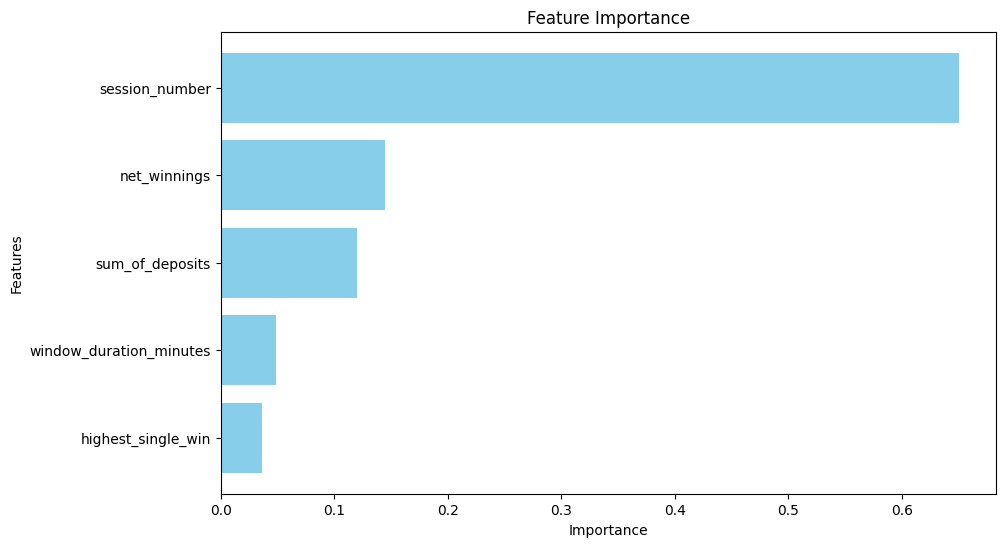

In [68]:
import matplotlib.pyplot as plt

feature_names = X.columns

# Extract feature importances
feature_importances = churn_classifier.feature_importances_

# Create a DataFrame to view the feature names and their corresponding importance
importances_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})

# Sort the DataFrame to show more important features at the top
importances_df = importances_df.sort_values(by="Importance", ascending=False)

# Display the DataFrame
print(importances_df)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df["Feature"], importances_df["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

# Model's behaviour on train_data

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.89      0.73      3234
           1       0.60      0.23      0.33      2315

    accuracy                           0.62      5549
   macro avg       0.61      0.56      0.53      5549
weighted avg       0.61      0.62      0.57      5549



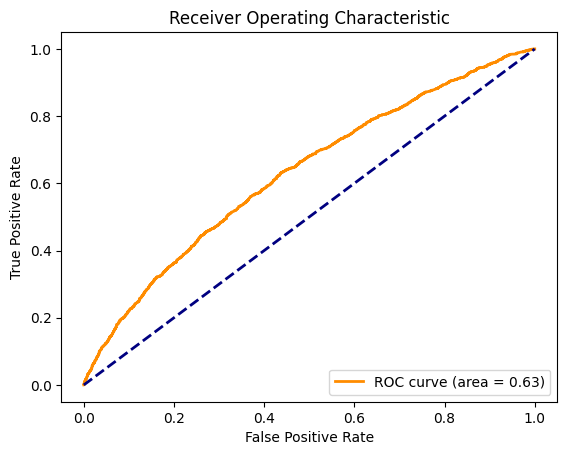

In [101]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Classification Report
cr = classification_report(y_test, churn_classifier.predict(X_test))
print("Classification Report:\n", cr)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, churn_classifier.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


# Test data injection

In [18]:
data_test = data_read_pl("data/test.csv")
print(data_test)


shape: (61_781, 11)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ user_id  ┆ session_n ┆ min_windo ┆ max_windo ┆ … ┆ sum_of_re ┆ highest_s ┆ highest_s ┆ sum_of_de │
│ ---      ┆ umber     ┆ w_timesta ┆ w_timesta ┆   ┆ al_wins   ┆ ingle_bet ┆ ingle_win ┆ posits    │
│ i64      ┆ ---       ┆ mp        ┆ mp        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆ i64       ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│          ┆           ┆ str       ┆ str       ┆   ┆           ┆           ┆           ┆           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 16960    ┆ 878       ┆ 2021-07-1 ┆ 2021-07-1 ┆ … ┆ 50.0      ┆ 2.3       ┆ 6.67      ┆ 8.33      │
│          ┆           ┆ 2         ┆ 2         ┆   ┆           ┆           ┆           ┆           │
│          ┆           ┆ 13:00:00  ┆ 13:30:00  ┆   ┆           ┆       

In [39]:
def get_last_sessions(data_test: pl.DataFrame):
    return data_test.sort("session_number", descending=True).group_by("user_id").head(1)


processed_test_df = get_last_sessions(data_test)
processed_test_df

user_id,session_number,min_window_timestamp,max_window_timestamp,count_of_bets,count_of_wins,sum_of_real_bets,sum_of_real_wins,highest_single_bet,highest_single_win,sum_of_deposits
i64,i64,str,str,i64,i64,f64,f64,f64,f64,f64
11442775,17,"""2021-07-03 17:45:00""","""2021-07-03 17:45:00""",5,1,0.08,0.0,0.02,0.0,0.0
11639791,4,"""2021-07-21 17:00:00""","""2021-07-21 17:45:00""",393,108,95.47,42.4,0.25,5.0,50.0
11191087,18,"""2021-07-07 18:30:00""","""2021-07-07 20:30:00""",433,220,167.77,103.15,0.83,8.96,64.17
9781717,129,"""2021-07-08 21:00:00""","""2021-07-08 21:15:00""",116,22,26.6,11.63,0.38,4.95,27.5
8674524,106,"""2021-07-20 18:00:00""","""2021-07-20 18:30:00""",237,46,45.48,28.8,0.43,8.67,16.67
…,…,…,…,…,…,…,…,…,…,…
6671670,294,"""2021-07-06 13:45:00""","""2021-07-06 14:15:00""",238,81,46.45,26.45,0.67,2.31,18.33
9711179,7,"""2021-07-16 11:30:00""","""2021-07-16 11:30:00""",1,0,0.17,0.0,0.17,0.0,0.0
11124583,30,"""2021-07-01 07:15:00""","""2021-07-01 07:15:00""",26,7,0.27,0.09,0.02,0.02,0.0


In [ ]:
fe_test = FeatureEngineering(processed_test_df, test=True)
data_test_1 = fe_test.finalize()

In [47]:
data_test_1

user_id,session_number,min_window_timestamp,max_window_timestamp,count_of_bets,count_of_wins,sum_of_real_bets,sum_of_real_wins,highest_single_bet,highest_single_win,sum_of_deposits,net_winnings,win_rate,window_duration,window_duration_minutes
i64,i64,datetime[μs],datetime[μs],i64,i64,f64,f64,f64,f64,f64,f64,f64,duration[μs],f64
11442775,17,2021-07-03 17:45:00,2021-07-03 17:45:00,5,1,0.08,0.0,0.02,0.0,0.0,-0.08,0.2,0µs,0.0
11639791,4,2021-07-21 17:00:00,2021-07-21 17:45:00,393,108,95.47,42.4,0.25,5.0,50.0,-53.07,0.274809,45m,45.0
11191087,18,2021-07-07 18:30:00,2021-07-07 20:30:00,433,220,167.77,103.15,0.83,8.96,64.17,-64.62,0.508083,2h,120.0
9781717,129,2021-07-08 21:00:00,2021-07-08 21:15:00,116,22,26.6,11.63,0.38,4.95,27.5,-14.97,0.189655,15m,15.0
8674524,106,2021-07-20 18:00:00,2021-07-20 18:30:00,237,46,45.48,28.8,0.43,8.67,16.67,-16.68,0.194093,30m,30.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6671670,294,2021-07-06 13:45:00,2021-07-06 14:15:00,238,81,46.45,26.45,0.67,2.31,18.33,-20.0,0.340336,30m,30.0
9711179,7,2021-07-16 11:30:00,2021-07-16 11:30:00,1,0,0.17,0.0,0.17,0.0,0.0,-0.17,0.0,0µs,0.0
11124583,30,2021-07-01 07:15:00,2021-07-01 07:15:00,26,7,0.27,0.09,0.02,0.02,0.0,-0.18,0.269231,0µs,0.0


In [50]:
clean_test_df = exclude_columns_pl(
    data_test_1,
    columns=[
        "win_rate",
        "window_duration",
        "min_window_timestamp",
        "max_window_timestamp",
    ],
)
clean_test_df = clean_test_df.filter(pl.col("window_duration_minutes") >= 0)
clean_test_df = fe.normalize_columns(clean_test_df, columns=clean_test_df.drop("user_id").columns)
clean_test_df

user_id,session_number,count_of_bets,count_of_wins,sum_of_real_bets,sum_of_real_wins,highest_single_bet,highest_single_win,sum_of_deposits,net_winnings,window_duration_minutes
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
11442775,0.00212,0.00072,0.000496,0.00001,0.0,0.000087,0.0,0.0,0.455314,0.0
11639791,0.0,0.056604,0.053518,0.012118,0.005697,0.001091,0.004246,0.075,0.420543,0.043478
11191087,0.002283,0.062365,0.109019,0.021295,0.013859,0.003622,0.007609,0.096255,0.412964,0.115942
9781717,0.020382,0.016707,0.010902,0.003376,0.001563,0.001658,0.004204,0.04125,0.445543,0.014493
8674524,0.016631,0.034135,0.022795,0.005773,0.00387,0.001876,0.007363,0.025005,0.444421,0.028986
…,…,…,…,…,…,…,…,…,…,…
6671670,0.047285,0.034279,0.040139,0.005896,0.003554,0.002924,0.001962,0.027495,0.442243,0.028986
9711179,0.000489,0.000144,0.0,0.000022,0.0,0.000742,0.0,0.0,0.455255,0.0
11124583,0.004239,0.003745,0.003469,0.000034,0.000012,0.000087,0.000017,0.0,0.455248,0.0


In [62]:
# Selecting the required columns from the test data to feed the model
features = ["session_number", "highest_single_win", "sum_of_deposits", "net_winnings", "window_duration_minutes"]
X_test = clean_test_df[features]
X_test

session_number,highest_single_win,sum_of_deposits,net_winnings,window_duration_minutes
f64,f64,f64,f64,f64
0.00212,0.0,0.0,0.455314,0.0
0.0,0.004246,0.075,0.420543,0.043478
0.002283,0.007609,0.096255,0.412964,0.115942
0.020382,0.004204,0.04125,0.445543,0.014493
0.016631,0.007363,0.025005,0.444421,0.028986
…,…,…,…,…
0.047285,0.001962,0.027495,0.442243,0.028986
0.000489,0.0,0.0,0.455255,0.0
0.004239,0.000017,0.0,0.455248,0.0


In [67]:
# Predicting probabilities of churn using X_test(class label 1)
churn_probabilities = churn_classifier.predict_proba(X_test)[:, 1]

# Create a DataFrame with user_id and their corresponding churn probabilities
output_df = clean_test_df.select(pl.col("user_id"))

# add the new series as a column
output_df = output_df.with_columns(pl.Series("churn_probability", churn_probabilities))
print(output_df)


shape: (2_018, 2)
┌──────────┬───────────────────┐
│ user_id  ┆ churn_probability │
│ ---      ┆ ---               │
│ i64      ┆ f64               │
╞══════════╪═══════════════════╡
│ 11442775 ┆ 0.679858          │
│ 11639791 ┆ 0.821103          │
│ 11191087 ┆ 0.788534          │
│ 9781717  ┆ 0.529875          │
│ 8674524  ┆ 0.655422          │
│ …        ┆ …                 │
│ 6671670  ┆ 0.558878          │
│ 9711179  ┆ 0.751071          │
│ 11124583 ┆ 0.655701          │
│ 4438077  ┆ 0.648398          │
│ 11072692 ┆ 0.657566          │
└──────────┴───────────────────┘


In [ ]:
count_no_churn = output_df.filter(pl.col("churn_probability") <= 0.5).shape[0]
count_churn = output_df.filter(pl.col("churn_probability") > 0.5).shape[0]
# count_unknown = output_df.filter(pl.col("churn_probability") == 0.5).shape[0]
total_players = output_df.shape[0]

In [108]:
print(f"""
    count_no_churn: {count_no_churn},
    ount_churn: {count_churn}
    ratio_churn(%): {round(count_churn * 100 / total_players, 2)}
""")


    count_no_churn: 193,
    count_churn: 1825
    ratio_churn(%): 90.44



In [104]:
output_df.filter(pl.col("churn_probability") >= 0.5)

user_id,churn_probability
i64,f64
11442775,0.679858
11639791,0.821103
11191087,0.788534
9781717,0.529875
8674524,0.655422
…,…
6671670,0.558878
9711179,0.751071
11124583,0.655701
